In [1]:
import sys
sys.path.insert(0, '../')
from nn_cno import nn_models
import numpy as np
import scipy as sp
import equinox as eqx
import optax
from jax.experimental import sparse
from jax import numpy as jnp
import jax
import matplotlib.pyplot as plt
import functools as ft

In [2]:
modelFile = "data/ToyNetRecurrent-Model.txt"
annotationFile = "data/ToyNetRecurrent-Annotation.txt"
parameterFile = "data/ToyNetRecurrent-Parameters.txt"

parameterizedModel = nn_models.bioNetwork(networkFile=modelFile, nodeAnnotationFile=annotationFile)
parameterizedModel.loadParams(parameterFile)

Model = nn_models.bioNetwork(networkFile=modelFile, nodeAnnotationFile=annotationFile)

Simulate some in-silico data

In [3]:
inputPoints = np.linspace(0, 1, num=10)
X = np.array(np.meshgrid(inputPoints, inputPoints)).T.reshape(-1, parameterizedModel.network.nInputs)
sim_batch = jax.vmap(parameterizedModel.model, in_axes=(0),out_axes=(0))
Y = sim_batch(X)

input shape:(2,)


In [4]:
testSelection = 'Random'
printSelection = True
if testSelection=='Random':
    nrOfTest = 20
    testSamples = np.random.permutation(len(Y))[0:nrOfTest]
elif testSelection=='VerticalStripe':
    condition = np.logical_or((X[:,0] == X[40,0]), (X[:,0] == X[50,0]))
    testSamples = np.argwhere(condition).flatten()
elif testSelection=='HorizontalStripe':
    condition = np.logical_or((X[:,1] == X[4,1]), (X[:,1] == X[5,1]))
    testSamples = np.argwhere(condition).flatten()
elif testSelection=='Boundary':
     testSamples = np.array([0, 1, 10, 11, 12, 22, 23, 33, 34, 44, 45, 54, 55, 64, 65, 74, 75, 84, 85, 94, 95])
elif testSelection=='SWQ':
     testSamples = np.array([0, 1, 2, 3, 4, 10, 11, 12, 13, 14, 20, 21, 22, 23, 24, 30, 31, 32, 33, 34])

trainSamples = np.array(range(X.shape[0]))
trainSamples= trainSamples[np.isin(trainSamples, testSamples)==False]


In [5]:
def contourPlot(X, Y, Z):
    import pandas as pd 
    import numpy
    import seaborn as sns
    df = pd.DataFrame.from_dict(np.array([X.flatten(), Y.flatten(), Z.flatten()]).T)
    df.columns = ['X_value','Y_value','Z_value']
    #df = df.round(1)
    pivotted = df.pivot('Y_value','X_value','Z_value')
    ax = sns.heatmap(pivotted, cmap='gray', vmin=0, vmax=1, square=True)
    ax.invert_yaxis()
    ax.set_ylabel('')
    ax.set_xlabel('')

    fmt = '{:0.1f}'
    xticklabels = []
    for item in ax.get_xticklabels():
        item.set_text(fmt.format(float(item.get_text())))
        xticklabels += [item]
    yticklabels = []
    for item in ax.get_yticklabels():
        item.set_text(fmt.format(float(item.get_text())))
        yticklabels += [item]
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)

    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    return pivotted

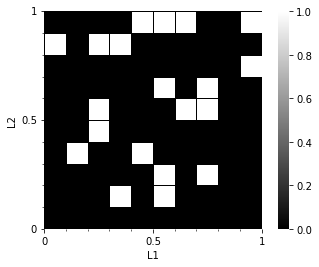

In [6]:
if printSelection:
    YTestPattern = np.zeros(Y.shape)
    YTestPattern[testSamples] = 1
    contourPlot(X[:, 0], X[:, 1], YTestPattern)
    plt.xticks([0,5,10], labels=['0', '0.5', '1'])
    plt.yticks([0,5,10], labels=['0', '0.5', '1'])
    plt.gca().set_xticks(list(range(0,11)), minor=True)
    plt.gca().set_yticks(list(range(0,11)), minor=True)
    plt.xlabel(parameterizedModel.network.inName[0])
    plt.ylabel(parameterizedModel.network.inName[1])
    plt.gcf().axes[1].set_label(parameterizedModel.network.outName[0])
    plt.gca().xaxis.grid(True, 'both', linewidth=1, color=[0,0,0])
    plt.gca().yaxis.grid(True, 'both', linewidth=1, color=[0,0,0])

Define training and test conditions: 

In [7]:
Xtest = X[testSamples,:]
Ytest = Y[testSamples]
X = X[trainSamples,:]
Y = Y[trainSamples]
N = X.shape[0]

In [8]:
# pytorch has a data loader, but jax does not.
# trainloader = torch.utils.data.DataLoader(range(N), batch_size=batchSize, shuffle=True)

# here we take the example from https://docs.kidger.site/equinox/examples/train_rnn/
# from equinox
import jax.random as jrandom

def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jrandom.permutation(key, indices)
        (key,) = jrandom.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size
            


In [9]:
#Setup optimizer
MoAFactor = 1
L2beta = 1e-8
spectralFactor = 0

def criterion(pred_y, y):
    # Trains with respect to binary cross-entropy
    return jnp.mean((y - pred_y) ** 2)


# jax/optax alternative: 
@eqx.filter_value_and_grad()
def compute_loss(model, x, y):
    
    pred_y = jax.vmap(model)(x)
    fitLoss = criterion(pred_y,y)

    # signConstraints
    violated_weights = model.layers[1].getViolations(model.layers[1].weights)
    signConstraint = MoAFactor * jnp.sum(jnp.abs(jnp.where(violated_weights,model.layers[1].weights,0)))

    ligandConstraint = 1e-1 * jnp.sum(jnp.square(model.layers[1].biases[model.layers[0].inOutIndices,0]))

    biasLoss = L2beta * jnp.sum(jnp.square(model.layers[1].biases))
    weightLoss = L2beta * jnp.sum(jnp.square(model.layers[1].weights))
    
    loss = fitLoss + signConstraint + ligandConstraint + biasLoss + weightLoss

    return loss

Let's see if we can add the constraints to the loss and JIT that function. 

In [10]:
# mean loss stored for reference
mLoss =  criterion(np.mean(Y,axis=0)*np.ones(Y.shape), Y)
mLoss

DeviceArray(0.21889491, dtype=float32)

In [11]:
def oneCycle(e, maxIter, maxHeight = 1e-3, startHeight=1e-5, endHeight=1e-5, minHeight = 1e-7, peak = 1000):
    phaseLength = 0.95 * maxIter
    if e<=peak:
        effectiveE = e/peak
        lr = (maxHeight-startHeight) * 0.5 * (np.cos(np.pi*(effectiveE+1))+1) + startHeight
    elif e<=phaseLength:
        effectiveE = (e-peak)/(phaseLength-peak)
        lr = (maxHeight-endHeight) * 0.5 * (np.cos(np.pi*(effectiveE+2))+1) + endHeight
    else:
        lr = endHeight
    return lr


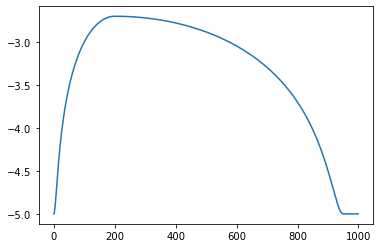

In [12]:
maxIter = 1000
lr = np.zeros((maxIter,))
e_vec = np.array(range(maxIter))
for e in range(maxIter):
    lr[e] = oneCycle(e, maxIter, maxHeight = 2e-3, minHeight = 1e-8, peak = 200)

fig, ax = plt.subplots()
ax.plot(e_vec, np.log10(lr))


In [13]:
# we have to use the partitioning trick for the make_step
@ft.partial(jax.jit, static_argnums=1)
def make_step(params,static, x, y, opt_state):
    model = eqx.combine(params, static)
    loss, grads = compute_loss(model, x, y)
    updates, opt_state = optim.update(grads, opt_state)
    params = eqx.apply_updates(params, updates)
    return loss, params, opt_state

## Check if the info goes through the makestep

In [14]:
# run a single step:
learning_rate = 1e-2
# setup optimizer
optim = optax.adam(learning_rate)
opt_state = optim.init(Model.model)

# setup the data: 
batch_size = 1
loader_key = jrandom.PRNGKey(142)
iter_data = dataloader((X, Y), batch_size, key=loader_key)
(x, y) = iter_data.__next__()


In [15]:
def printParameters(model):
    print("Input layer:")
    print(model.layers[0].weights)

    print("Recurrent layer:")
    print(model.layers[1].weights)
    print(model.layers[1].biases.T)

    print("Output layer:")
    print(model.layers[2].weights)


In [16]:
printParameters(Model.model)

Input layer:
[1. 1.]
Recurrent layer:
[ 0.13359572  0.16775657  0.17122287  0.17099628 -0.12042612  0.18854043
 -0.14916968  0.11891927]
[[0.001 0.001 0.001 0.001 0.001 0.001 0.001]]
Output layer:
[1.]


In [17]:
# partition model: 
params, static = eqx.partition(Model.model, eqx.is_array)
printParameters(params)

Input layer:
[1. 1.]
Recurrent layer:
[ 0.13359572  0.16775657  0.17122287  0.17099628 -0.12042612  0.18854043
 -0.14916968  0.11891927]
[[0.001 0.001 0.001 0.001 0.001 0.001 0.001]]
Output layer:
[1.]


In [18]:
# make a step
loss, params, opt_state = make_step(params, static, x, y, opt_state)

input shape:(2,)


In [19]:
printParameters(params)

Input layer:
[0.9900007 1.0099999]
Recurrent layer:
[ 0.12359582  0.15776043  0.1812228   0.16099639 -0.130426    0.19854036
 -0.13916986  0.1289192 ]
[[-0.00899967  0.01099991 -0.00899991  0.01099993 -0.00899993  0.01099993
   0.01099993]]
Output layer:
[1.0099999]


In [20]:
# optimization with fixed learning rate: 

optim = optax.adam(learning_rate)
opt_state = optim.init(Model.model)
resetState = opt_state # state is a tuple, copy it by assignmment
params, static = eqx.partition(Model.model, eqx.is_array)

maxIter = 1000
progress = nn_models.rnnModel.OptimProgress(maxIter)
steps = X.shape[0]
iter_data = dataloader((X, Y), batch_size, key=loader_key)

for e in range(maxIter):

    currentLoss = []
    
    for step, (x, y) in zip(range(steps), iter_data):
        
        loss, params, opt_state = make_step(params, static, x, y, opt_state)
        
        currentLoss.append(loss.item())

    trained_model = eqx.combine(params, static)
    # compute progress on the validation set:     
    #Yhat = jax.vmap(Model.model)(Xtest)
    #fitLoss = criterion(Yhat,Ytest)

    progress.stats['violations'][e] = np.sum(trained_model.layers[1].getViolations()).item()
    #stats['test'][e] = fitLoss.item()
    progress.storeProgress(loss=currentLoss, lr=learning_rate, violations=np.sum(trained_model.layers[1].getViolations(trained_model.layers[1].weights)).item())

    if e % 50 == 0:
        progress.printStats(e)

    if np.logical_and(e % 100 == 0, e>0):
        opt_state = resetState




i=0, l=0.25842, r=0.01000, v=0
i=50, l=0.01506, r=0.01000, v=0
i=100, l=0.00379, r=0.01000, v=0
i=150, l=0.03428, r=0.01000, v=0
i=200, l=0.02040, r=0.01000, v=0
i=250, l=0.03801, r=0.01000, v=0
i=300, l=0.02798, r=0.01000, v=0
i=350, l=0.07670, r=0.01000, v=0
i=400, l=0.03854, r=0.01000, v=0
i=450, l=0.00307, r=0.01000, v=0
i=500, l=0.06874, r=0.01000, v=0
i=550, l=0.00229, r=0.01000, v=0
i=600, l=0.01160, r=0.01000, v=0
i=650, l=0.00836, r=0.01000, v=0
i=700, l=0.00723, r=0.01000, v=0
i=750, l=0.02713, r=0.01000, v=0
i=800, l=0.00350, r=0.01000, v=0
i=850, l=0.00645, r=0.01000, v=0
i=900, l=0.01300, r=0.01000, v=0
i=950, l=0.00551, r=0.01000, v=0


In [23]:
# optimization with adaptive/scheduled learning rate. 
# option 1: https://github.com/deepmind/optax/issues/4 --> looks outdatad, the syntax of adam does not match
# option 2: https://github.com/deepmind/optax/discussions/262  -> insert as hyperparameter

optim = optax.inject_hyperparams(optax.adam)(learning_rate=1)
opt_state = optim.init(Model.model)

resetState = opt_state # state is a tuple, copy it by assignmment
params, static = eqx.partition(Model.model, eqx.is_array)

maxIter = 1000
progress = nn_models.rnnModel.OptimProgress(maxIter)
steps = X.shape[0]
iter_data = dataloader((X, Y), batch_size, key=loader_key)

for e in range(maxIter):

    currentLoss = []
    learning_rate_e = oneCycle(e, maxIter, maxHeight = 2e-3, minHeight = 1e-8, peak = 200)
    opt_state.hyperparams['learning_rate'] = learning_rate_e
    
    for step, (x, y) in zip(range(steps), iter_data):
        
        loss, params, opt_state = make_step(params, static, x, y, opt_state)
        
        currentLoss.append(loss.item())

    trained_model = eqx.combine(params, static)
    # compute progress on the validation set:     
    #Yhat = jax.vmap(Model.model)(Xtest)
    #fitLoss = criterion(Yhat,Ytest)
    
    progress.stats['violations'][e] = np.sum(trained_model.layers[1].getViolations()).item()
    #stats['test'][e] = fitLoss.item()
    progress.storeProgress(loss=currentLoss, lr=learning_rate_e, violations=np.sum(trained_model.layers[1].getViolations(trained_model.layers[1].weights)).item())

    if e % 50 == 0:
        progress.printStats(e)

    if np.logical_and(e % 100 == 0, e>0):
        opt_state = resetState




i=0, l=0.51917, r=0.00001, v=0
i=50, l=0.17556, r=0.00030, v=0
i=100, l=0.01168, r=0.00100, v=0
i=150, l=0.01714, r=0.00171, v=0
i=200, l=0.00088, r=0.00200, v=0
i=250, l=0.00033, r=0.00198, v=0
i=300, l=0.00022, r=0.00191, v=0
i=350, l=0.00007, r=0.00181, v=0
i=400, l=0.00015, r=0.00167, v=0
i=450, l=0.00005, r=0.00150, v=0
i=500, l=0.00004, r=0.00131, v=0
i=550, l=0.00010, r=0.00111, v=0
i=600, l=0.00002, r=0.00090, v=0
i=650, l=0.00002, r=0.00070, v=0
i=700, l=0.00001, r=0.00051, v=0
i=750, l=0.00001, r=0.00034, v=0
i=800, l=0.00001, r=0.00020, v=0
i=850, l=0.00001, r=0.00010, v=0
i=900, l=0.00001, r=0.00003, v=0
i=950, l=0.00001, r=0.00001, v=0
input shape:(2,)


# Playground and tests

In [7]:
parameterizedModel.model.layers[1].weights


DeviceArray([ 1. ,  1.4,  1. ,  1. , -0.9,  1. , -1. ,  2. ], dtype=float32)

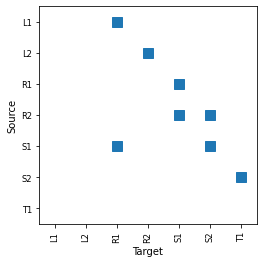

In [43]:
parameterizedModel.network.plot()

In [44]:
parameterizedModel.network.A.todense()

matrix([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  1.,  0.],
        [ 0.,  0.,  1.,  0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]])

figure out inputLayer: 

In [45]:
x = jnp.ones((1,10))
size_out = 20
size_in = 10
inOutIndices = np.array([0,1,2,3,4,5,6,7,8,10])
weights = 5.0



In [46]:
%%timeit
y = np.zeros([x.shape[0],  size_out])
y[:, inOutIndices] = weights * x
jnp.array(y)




146 µs ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [47]:
%%timeit
y = jnp.zeros([x.shape[0],  size_out])
y.at[:,inOutIndices].set(weights * x)


1.62 ms ± 70.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [48]:
tt = [True if i in inOutIndices else False for i in range(size_out)] 


Figure out output layers

In [49]:
x = jnp.array(range(20)).reshape(1,20)
size_out = 10
size_in = 20
inOutIndices = np.array([0,1,2,3,4,5,6,7,8,10])
weights = 0.7

x

DeviceArray([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
              15, 16, 17, 18, 19]], dtype=int32)

In [50]:
#%%timeit
y = np.zeros([x.shape[0],  size_out])
weights * x[:, inOutIndices]
#jnp.array(y)

DeviceArray([[0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 7. ]],            dtype=float32, weak_type=True)

In [51]:
jnp.zeros((10,))

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [52]:
key = jax.random.PRNGKey(1987)

In [53]:
weights = 0.1 + 0.1 * np.random.uniform(size=(8,))
weights

array([0.15630224, 0.19508493, 0.18640879, 0.19632766, 0.1863483 ,
       0.18440369, 0.10717691, 0.13916991])

In [54]:
parameterizedModel.network.modeOfAction[1,:].shape

(8,)

In [55]:
weights[parameterizedModel.network.modeOfAction[1,:]] = -weights[parameterizedModel.network.modeOfAction[1,:]]
weights

array([ 0.15630224,  0.19508493,  0.18640879,  0.19632766, -0.1863483 ,
        0.18440369, -0.10717691,  0.13916991])

In [56]:
parameterizedModel.network.modeOfAction[0]

array([ True,  True,  True,  True, False,  True, False,  True])

In [57]:
x = jnp.array(range(20)).reshape(1,20)

In [58]:
x

DeviceArray([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
              15, 16, 17, 18, 19]], dtype=int32)

In [59]:
x.transpose()

DeviceArray([[ 0],
             [ 1],
             [ 2],
             [ 3],
             [ 4],
             [ 5],
             [ 6],
             [ 7],
             [ 8],
             [ 9],
             [10],
             [11],
             [12],
             [13],
             [14],
             [15],
             [16],
             [17],
             [18],
             [19]], dtype=int32)

In [3]:
IPL = nn_models.rnnModel.inputProjectionLayer(size_in=3,
                                            size_out=20,
                                            inOutIndices=[0,5,10],
                                            weight = 2.0)
IPL(jnp.ones((2,3)))

DeviceArray([[2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
              0., 0., 0., 0., 0.],
             [2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
              0., 0., 0., 0., 0.]], dtype=float32)

In [4]:
OPL = nn_models.rnnModel.outputProjectionLayer(size_in=20,
                                            size_out=4,
                                            inOutIndices=[0,5,10, 15],
                                            weight = 2.0)
OPL(jnp.ones((2,20)))

DeviceArray([[2., 2., 2., 2.],
             [2., 2., 2., 2.]], dtype=float32)

In [9]:
parameterizedModel.network.nodeNames

['L1', 'L2', 'R1', 'R2', 'S1', 'S2', 'T1']

In [8]:
weights = 0.1 + 0.1 * np.random.uniform(size=(8,))
print(weights.shape)
print(parameterizedModel.network.modeOfAction[1,:].shape)

weights[parameterizedModel.network.modeOfAction[1,:]]

(8,)
(8,)


array([0.13346492, 0.16542737])

In [5]:
RL = nn_models.rnnModel.recurrentLayer(nStates=len(parameterizedModel.network.nodeNames),
                                    modeOfAction=parameterizedModel.network.modeOfAction,
                                    networkList= parameterizedModel.network.networkList,
                                    iterations = 100,
                                    leak=0.01)
                       

In [6]:
RL(jnp.ones((len(parameterizedModel.network.nodeNames),len(parameterizedModel.network.nodeNames))))

DeviceArray([[0.75024974, 0.75024974, 0.78538847, 0.78043336, 0.73708916,
              0.7572291 , 0.774161  ],
             [0.75024974, 0.75024974, 0.78538847, 0.78043336, 0.73708916,
              0.7572291 , 0.774161  ],
             [0.75024974, 0.75024974, 0.78538847, 0.78043336, 0.73708916,
              0.7572291 , 0.774161  ],
             [0.75024974, 0.75024974, 0.78538847, 0.78043336, 0.73708916,
              0.7572291 , 0.774161  ],
             [0.75024974, 0.75024974, 0.78538847, 0.78043336, 0.73708916,
              0.7572291 , 0.774161  ],
             [0.75024974, 0.75024974, 0.78538847, 0.78043336, 0.73708916,
              0.7572291 , 0.774161  ],
             [0.75024974, 0.75024974, 0.78538847, 0.78043336, 0.73708916,
              0.7572291 , 0.774161  ]], dtype=float32)

In [12]:
type(parameterizedModel.network.networkList)

numpy.ndarray

In [4]:
parameterizedModel.trainingParameters.iterations

150

In [3]:
BM = nn_models.rnnModel.BionetworkModel(parameterizedModel.network.networkList,
                parameterizedModel.network.nodeNames,
                parameterizedModel.network.modeOfAction,
                1.1, 0.7,
                parameterizedModel.network.inName,
                parameterizedModel.network.outName,
                parameterizedModel.trainingParameters
 )

In [11]:
x = jnp.ones((1,len(parameterizedModel.network.inName)))
y = np.array([0.798])

In [15]:
BM(x)

DeviceArray([[0.00214212]], dtype=float32)

In [16]:
jax.np.mean((y - BM(x)) ** 2)

DeviceArray(0.6333897, dtype=float32)

In [6]:
import functools as ft

In [29]:
@ft.partial(jax.jit, static_argnums=1)
@jax.grad
def loss(params, static, x, y):
    model = eqx.combine(params, static)
    pred_y = jax.vmap(model)(x)
    return jax.np.mean((y - pred_y) ** 2)

params, static = eqx.partition(BM, eqx.is_array)
loss(params,static, x, y)

BionetworkModel(
  layers=[
    inputProjectionLayer(
      weights=f32[2],
      size_in=2,
      size_out=7,
      inOutIndices=i64[2](numpy)
    ),
    recurrentLayer(
      weights=f32[8],
      biases=f32[7,1],
      nStates=7,
      nReactions=8,
      modeOfAction=bool[2,8](numpy),
      networkList=i32[2,8](numpy),
      iterations=150,
      leak=0.01,
      A=JVPTracer[BCOO(float32[7, 7], nse=8)],
      activation=<function MMLactivation>
    ),
    outputProjectionLayer(
      weights=f32[1],
      size_in=7,
      size_out=1,
      inOutIndices=i64[1](numpy)
    )
  ]
)

In [30]:
g_loss = loss(params,static, x, y)

In [35]:
g_loss.layers[0].weights

DeviceArray([ 0.00013033, -0.00070299], dtype=float32)

In [36]:
BM.layers[0].weights

DeviceArray([1.1, 1.1], dtype=float32)

Sparse matrices in JAX
- this is experimental 

In [8]:
parameterizedModel.network.

In [5]:
weights

DeviceArray([[1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)

In [4]:
data_location

array([[2, 2, 3, 4, 4, 5, 5, 6],
       [0, 4, 1, 2, 3, 3, 4, 5]], dtype=int32)

In [6]:
weights = jnp.ones(parameterizedModel.network.nReactions)
data_location = parameterizedModel.network.networkList
nStates = parameterizedModel.network.nStates
scipyA =  sp.sparse.csr_matrix((weights, data_location), shape=(nStates, nStates))
scipyA      
      

<7x7 sparse matrix of type '<class 'numpy.float32'>'
	with 8 stored elements in Compressed Sparse Row format>

In [7]:
A = sparse.BCOO.from_scipy_sparse(scipyA)

In [8]:
A

BCOO(float32[7, 7], nse=8)

In [11]:
weights = 0.7*jnp.ones(parameterizedModel.network.nReactions)
A.data = weights

In [12]:
A

BCOO(float32[7, 7], nse=8)

In [16]:
A.indices

DeviceArray([[2, 0],
             [2, 4],
             [3, 1],
             [4, 2],
             [4, 3],
             [5, 3],
             [5, 4],
             [6, 5]], dtype=int32)

In [17]:
data_location

array([[2, 2, 3, 4, 4, 5, 5, 6],
       [0, 4, 1, 2, 3, 3, 4, 5]], dtype=int32)

In [18]:
A

BCOO(float32[7, 7], nse=8)

In [27]:
x = jnp.ones((parameterizedModel.network.nStates,))
x

DeviceArray([1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [28]:
A @ x

DeviceArray([0. , 0. , 1.4, 0.7, 1.4, 1.4, 0.7], dtype=float32)

In [29]:
x = jnp.ones((parameterizedModel.network.nStates,1))

In [30]:
A @ x

DeviceArray([[0. ],
             [0. ],
             [1.4],
             [0.7],
             [1.4],
             [1.4],
             [0.7]], dtype=float32)